In [1]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import time

In [2]:
conn = psycopg2.connect(dbname =   'sync3', 
                        user =     'postgres', 
                        password = 'sync3',
                        host =     '141.100.70.97')

# Business, Category, Attribute, Hours
#SQL_business = """SELECT business.bid, business.clusterid, business.stars, business.revcount, business.name, 
#                   business.city, business.state, business.pcode, business.lon, business.lat, 
#                   categories.cat, attribute.attr, hours.dow, hours.open, hours.close
#                  FROM business
#                  RIGHT JOIN category ON category.bid = business.bid
#                  LEFT JOIN categories ON categories.cid = category.cid
#                  RIGHT JOIN attribute ON attribute.bid = business.bid
#                  RIGHT JOIN hours ON hours.bid = business.bid
#                  WHERE business.revcount > 30 AND categories.cat in ('Food','Restaurants','Nightlife')
#               """

# Business
SQL_business = """SELECT business.bid, business.clusterid, business.stars, business.revcount, business.name, 
                   business.city, business.state, business.pcode, categories.cat
                  FROM business
                  RIGHT JOIN category ON category.bid = business.bid
                  LEFT JOIN categories ON categories.cid = category.cid
                  WHERE business.revcount > 30 AND categories.cat in ('Food','Restaurants','Nightlife')
               """

# Categories
SQL_categories = """SELECT business.bid, business.clusterid, categories.cat
                    FROM business
                    RIGHT JOIN category ON category.bid = business.bid
                    LEFT JOIN categories ON categories.cid = category.cid
                 """

# Checkins
SQL_checkins = """SELECT bid, date, amount
                  FROM checkins        
               """

# Cluster Weather
SQL_wetter = """SELECT clusterid, date, tmin, tmax, snow, snowdepth, perception
                FROM cluster_weather
             """

# Reviews
SQL_reviews = """SELECT rid, bid, star, date, interactions, text as rev_text
                 FROM reviews
             """

# Reviews, Users, Tips
#SQL_reviews = """SELECT reviews.bid, reviews.star, reviews.date, reviews.interactions, reviews.text as rev_text,
#                   users.revcount, users.friends, users.fans, users.avgstars, users.interaction,
#                   tips.compliments, tips.text as tips_text
#                 FROM reviews
#                 LEFT JOIN users ON users.uid = reviews.uid
#                 LEFT JOIN tips ON tips.bid = reviews.bid AND tips.uid = users.uid
#             """

In [3]:
start = time.time()
wetter = pd.read_sql_query(SQL_wetter, conn)
end = time.time()
print(f"Wetter-Daten geladen in {round(end-start,2)}")

start = time.time()
categories = pd.read_sql_query(SQL_categories, conn)
end = time.time()
print(f"Kategorie-Daten geladen in {round(end-start,2)}")

start = time.time()
business = pd.read_sql_query(SQL_business, conn)
end = time.time()
print(f"Business-Daten geladen in {round(end-start,2)}")

start = time.time()
checkins = pd.read_sql_query(SQL_checkins, conn)
end = time.time()
print(f"Checkin-Daten geladen in {round(end-start,2)}")

start = time.time()
reviews = pd.read_sql_query(SQL_reviews, conn)
end = time.time()
print(f"Review-Daten geladen in {round(end-start,2)}")

Wetter-Daten geladen in 1.56
Kategorie-Daten geladen in 7.81
Business-Daten geladen in 0.89
Checkin-Daten geladen in 147.02
Review-Daten geladen in 1332.73


In [4]:
# Clean DF
business = business.loc[:,~business.columns.duplicated()]
wetter = wetter.loc[:,~wetter.columns.duplicated()]
checkins = checkins.loc[:,~checkins.columns.duplicated()]
reviews = reviews.loc[:,~reviews.columns.duplicated()]

# Filter Reviews, Checkins
bids = business['bid'].to_numpy().tolist()
revs = reviews[reviews['bid'].isin(bids)].reset_index()
checks = checkins[checkins['bid'].isin(bids)].reset_index()
cats = categories[categories['bid'].isin(bids)].reset_index()

# Rename DF
df_b = business.dropna()
df_w = wetter.dropna()
df_r = revs.dropna()
df_c = checks.dropna()
df_ca = cats.dropna()

In [5]:
df_c = df_c.drop(columns = ['index'])
df_r = df_r.drop(columns = ['index','rev_text'])
df_ca = df_ca.drop(columns = ['index'])

In [7]:
df_w['month'] = pd.DatetimeIndex(df_w['date']).month
df_w['year'] = pd.DatetimeIndex(df_w['date']).year
df_r['month'] = pd.DatetimeIndex(df_r['date']).month
df_r['year'] = pd.DatetimeIndex(df_r['date']).year
df_c['month'] = pd.DatetimeIndex(df_c['date']).month
df_c['year'] = pd.DatetimeIndex(df_c['date']).year

C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


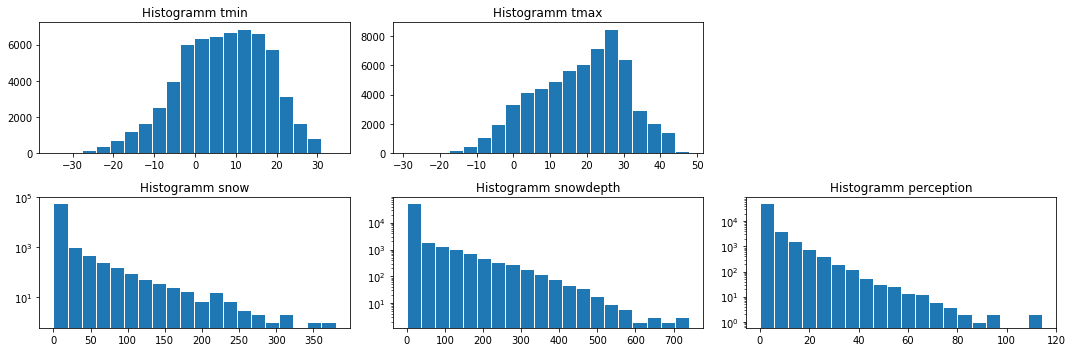

In [8]:
fig, axes = plt.subplots(2, 3, figsize=(15, 5), tight_layout = True)

axes[0,0].hist(df_w['tmin'], bins = 20, edgecolor = 'white')
axes[0,0].set_title('Histogramm tmin')

axes[0,1].hist(df_w['tmax'], bins = 20, edgecolor = 'white')
axes[0,1].set_title('Histogramm tmax')

axes[0,2].axis('off')

axes[1,0].hist(df_w['snow'], bins = 20, edgecolor = 'white', log = True)
axes[1,0].set_title('Histogramm snow')

axes[1,1].hist(df_w['snowdepth'], bins = 20, edgecolor = 'white', log = True)
axes[1,1].set_title('Histogramm snowdepth')

axes[1,2].hist(df_w['perception'], bins = 20, edgecolor = 'white', log = True)
axes[1,2].set_title('Histogramm perception')

plt.show()

In [125]:
# Left Join Reviews - Businesses
df_r_b = pd.merge(df_r, df_b, how = 'left', on='bid', suffixes = ('_rev','_bus'))

In [126]:
# Left Join Reviews - Businesses - Wetter
df_r_w = pd.merge(df_r_b, df_w, how = 'left', on=['date','clusterid'])

In [127]:
df_r_w['tmin_cat'] = pd.cut(df_r_w['tmin'], bins=[-35, -10, 0, 10, 20, 30, 50], right=False)
df_r_w['tmax_cat'] = pd.cut(df_r_w['tmax'], bins=[-35, -10, 0, 10, 20, 30, 50], right=False)
df_r_w['snow_cat'] = pd.cut(df_r_w['snow'], bins=[0, 5, 25, 50, 100, 1000], right=False)
df_r_w['snowdepth_cat'] = pd.cut(df_r_w['snowdepth'], bins=[0, 25, 50, 100, 200, 1000], right=False)
df_r_w['perception_cat'] = pd.cut(df_r_w['perception'], bins=[0, 2, 8, 15, 30, 200], right=False)

In [128]:
df_r_w['year'] = df_r_w['year_x']
df_r_w['month'] = df_r_w['month_x']
df_r_w = df_r_w.drop(columns = ['year_x', 'year_y', 'month_x', 'month_y'])

In [129]:
def show_values_on_bars(axs, decimal):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.01*p.get_height()
            if decimal == True:
                value = '{:.2f}'.format(p.get_height())
            else:
                value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

# Tmin vs. Reviews

In [147]:
plot_df = df_r_w.groupby(['tmin_cat'], as_index=False)\
                .agg({'star': 'mean', 'rid': 'nunique'})

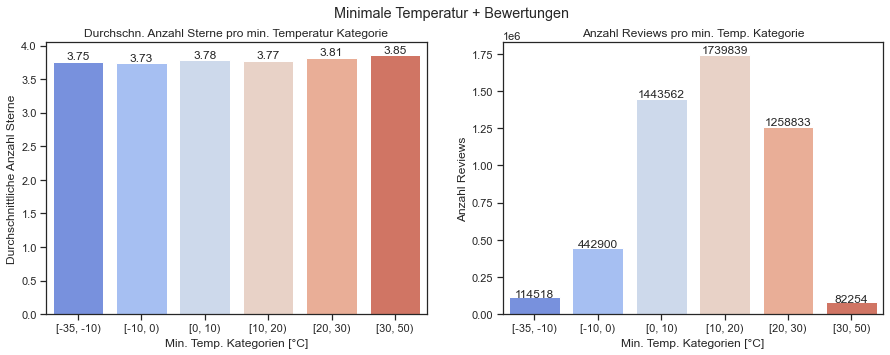

In [148]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Minimale Temperatur + Bewertungen')

sns.set(style='ticks')
g = sns.barplot(ax = axes[0],
            x = 'tmin_cat',
            y = 'star',
            data = plot_df,
            palette = 'coolwarm')
axes[0].set_title('Durchschn. Anzahl Sterne pro min. Temperatur Kategorie')
axes[0].set_xlabel('Min. Temp. Kategorien [°C]')
axes[0].set_ylabel('Durchschnittliche Anzahl Sterne')

show_values_on_bars(axes[0], True)

sns.barplot(ax = axes[1],
            x = 'tmin_cat',
            y = 'rid',
            data = plot_df,
            palette = 'coolwarm')
axes[1].set_title('Anzahl Reviews pro min. Temp. Kategorie')
axes[1].set_xlabel('Min. Temp. Kategorien [°C]')
axes[1].set_ylabel('Anzahl Reviews')

show_values_on_bars(axes[1], False)

#plt.show()
plt.savefig('tmin_review.png')

# Tmax vs. Reviews

In [149]:
plot_df = df_r_w.groupby(['tmax_cat'], as_index=False)\
                .agg({'star': 'mean', 'rid': 'nunique'})

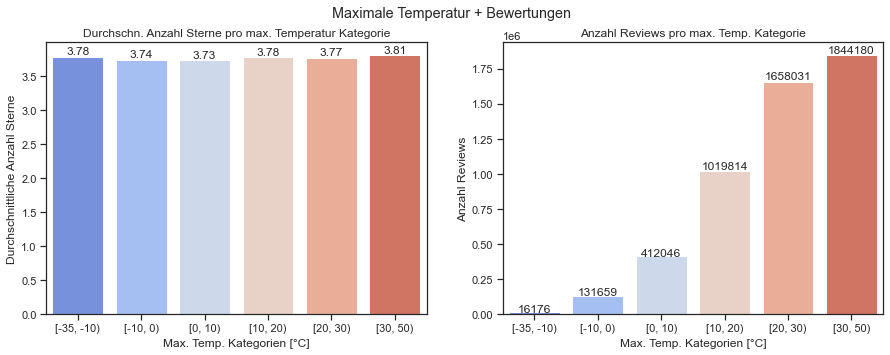

In [150]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Maximale Temperatur + Bewertungen')

sns.set(style='ticks')
sns.barplot(ax = axes[0],
            x = 'tmax_cat',
            y = 'star',
            data = plot_df,
            palette = 'coolwarm')
axes[0].set_title('Durchschn. Anzahl Sterne pro max. Temperatur Kategorie')
axes[0].set_xlabel('Max. Temp. Kategorien [°C]')
axes[0].set_ylabel('Durchschnittliche Anzahl Sterne')

show_values_on_bars(axes[0], True)

sns.barplot(ax = axes[1],
            x = 'tmax_cat',
            y = 'rid',
            data = plot_df,
            palette = 'coolwarm')
axes[1].set_title('Anzahl Reviews pro max. Temp. Kategorie')
axes[1].set_xlabel('Max. Temp. Kategorien [°C]')
axes[1].set_ylabel('Anzahl Reviews')

show_values_on_bars(axes[1], False)

#plt.show()
plt.savefig('tmax_review.png')

# Snow vs. Reviews

In [151]:
plot_df = df_r_w.groupby(['snow_cat'], as_index=False)\
                .agg({'star': 'mean', 'rid': 'nunique'})

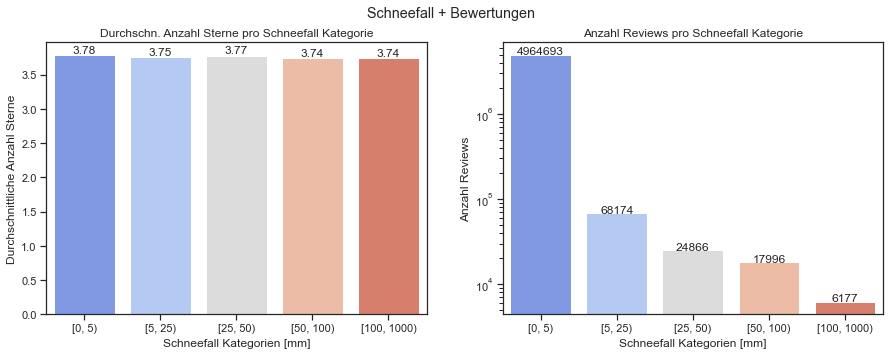

In [152]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Schneefall + Bewertungen')

sns.set(style='ticks')
sns.barplot(ax = axes[0],
            x = 'snow_cat',
            y = 'star',
            data = plot_df,
            palette = 'coolwarm')
axes[0].set_title('Durchschn. Anzahl Sterne pro Schneefall Kategorie')
axes[0].set_xlabel('Schneefall Kategorien [mm]')
axes[0].set_ylabel('Durchschnittliche Anzahl Sterne')

show_values_on_bars(axes[0], True)

sns.barplot(ax = axes[1],
            x = 'snow_cat',
            y = 'rid',
            data = plot_df,
            palette = 'coolwarm',
            log = True)
axes[1].set_title('Anzahl Reviews pro Schneefall Kategorie')
axes[1].set_xlabel('Schneefall Kategorien [mm]')
axes[1].set_ylabel('Anzahl Reviews')

show_values_on_bars(axes[1], False)

#plt.show()
plt.savefig('snow_review.png')

# Snowdepth + Reviews

In [154]:
plot_df = df_r_w.groupby(['snowdepth_cat'], as_index=False)\
                .agg({'star': 'mean', 'rid': 'nunique'})

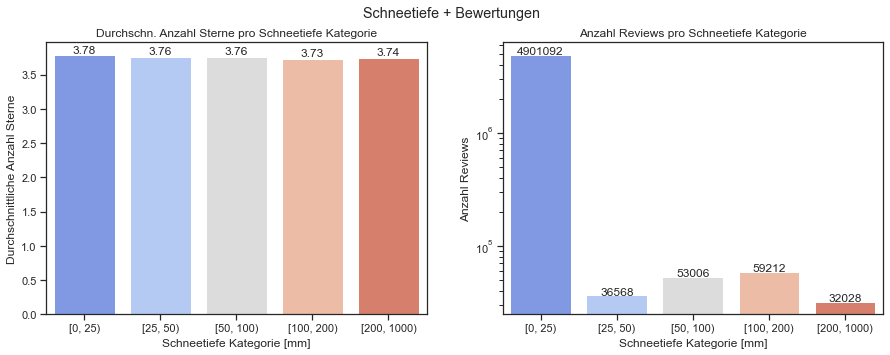

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Schneetiefe + Bewertungen')

sns.set(style='ticks')
sns.barplot(ax = axes[0],
            x = 'snowdepth_cat',
            y = 'star',
            data = plot_df,
            palette = 'coolwarm')
axes[0].set_title('Durchschn. Anzahl Sterne pro Schneetiefe Kategorie')
axes[0].set_xlabel('Schneetiefe Kategorie [mm]')
axes[0].set_ylabel('Durchschnittliche Anzahl Sterne')

show_values_on_bars(axes[0], True)

sns.barplot(ax = axes[1],
            x = 'snowdepth_cat',
            y = 'rid',
            data = plot_df,
            palette = 'coolwarm',
            log = True)
axes[1].set_title('Anzahl Reviews pro Schneetiefe Kategorie')
axes[1].set_xlabel('Schneetiefe Kategorie [mm]')
axes[1].set_ylabel('Anzahl Reviews')

show_values_on_bars(axes[1], False)

#plt.show()
plt.savefig('snowdepth_review.png')

# Niederschlag + Reviews

In [158]:
plot_df = df_r_w.groupby(['perception_cat'], as_index=False)\
                .agg({'star': 'mean', 'rid': 'nunique'})

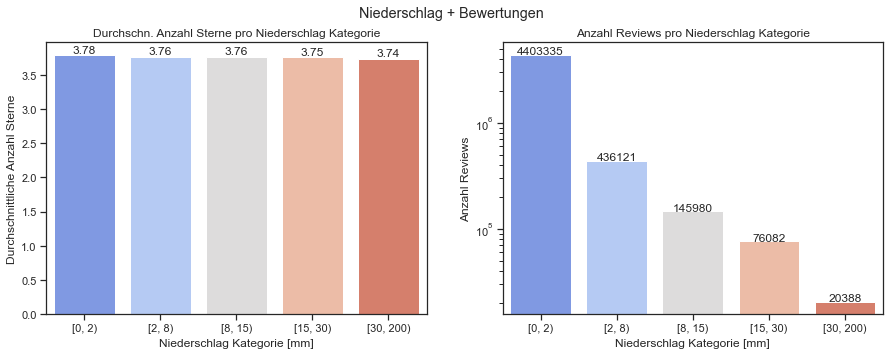

In [160]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Niederschlag + Bewertungen')

sns.set(style='ticks')
sns.barplot(ax = axes[0],
            x = 'perception_cat',
            y = 'star',
            data = plot_df,
            palette = 'coolwarm')
axes[0].set_title('Durchschn. Anzahl Sterne pro Niederschlag Kategorie')
axes[0].set_xlabel('Niederschlag Kategorie [mm]')
axes[0].set_ylabel('Durchschnittliche Anzahl Sterne')

show_values_on_bars(axes[0], True)

sns.barplot(ax = axes[1],
            x = 'perception_cat',
            y = 'rid',
            data = plot_df,
            palette = 'coolwarm',
            log = True)
axes[1].set_title('Anzahl Reviews pro Niederschlag Kategorie')
axes[1].set_xlabel('Niederschlag Kategorie [mm]')
axes[1].set_ylabel('Anzahl Reviews')

show_values_on_bars(axes[1], False)

#plt.show()
plt.savefig('precipitation_review.png')

## Anzahl Sterne vs. Niederschlagsmenge

In [25]:
plot_df = df_r_w[['star','perception']]

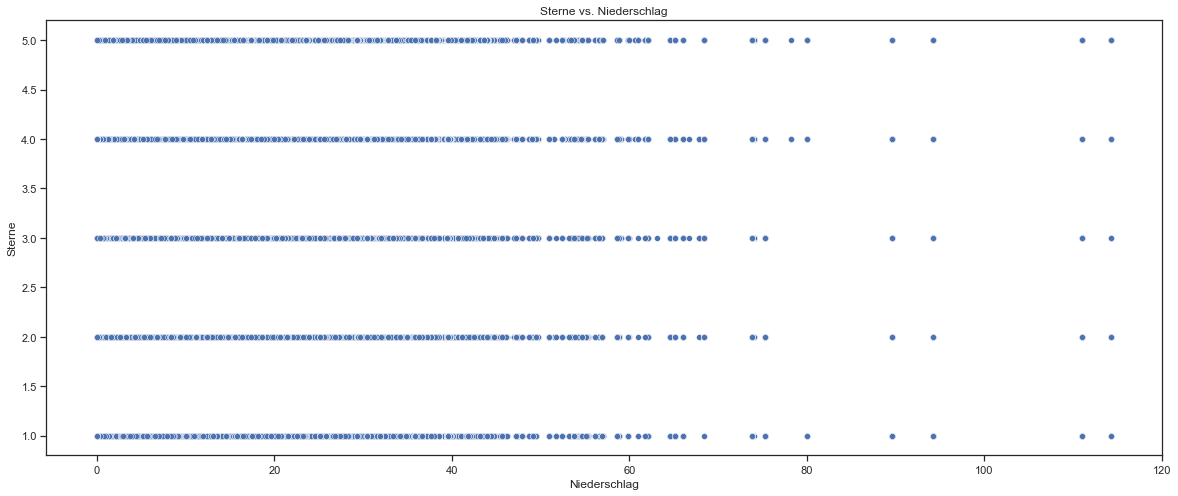

In [26]:
plt.figure(figsize = (20,8))
sns.set(style='ticks')
sns.scatterplot(x = 'perception',
            y = 'star',
            #hue = hue,
            data = plot_df,
            palette = 'hls',
            x_jitter = True)
plt.title("Sterne vs. Niederschlag")
plt.xlabel("Niederschlag")
plt.ylabel("Sterne")
plt.show()

In [29]:
plot_df = df_r_w[['year','star','perception']]
plot_df = plot_df[plot_df['year'] == 2018]

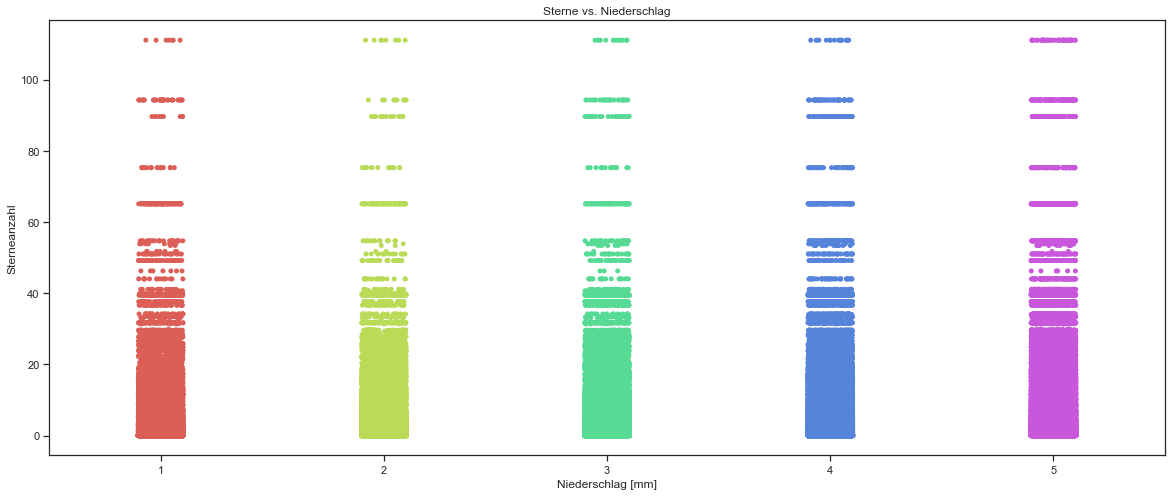

In [34]:
plt.figure(figsize = (20,8))
sns.set(style='ticks')
sns.stripplot(x = 'star',
              y = 'perception',
            #hue = hue,
            data = plot_df,
            palette = 'hls',
            jitter = True)
plt.title("Sterne vs. Niederschlag")
plt.ylabel("Sterneanzahl")
plt.xlabel("Niederschlag [mm]")
plt.show()

In [77]:
df_r_w.corr(method='spearman')

,star,interactions,clusterid,stars,revcount,tmin,tmax,snow,snowdepth,perception,year,month
star,1.000000,-0.102702,-0.039819,0.385072,0.104745,0.030817,0.032465,-0.014365,-0.019465,-0.019628,0.078877,0.000255
interactions,-0.102702,1.000000,-0.003591,-0.016761,-0.045985,-0.033754,-0.032814,0.023119,0.027558,0.011982,-0.197164,-0.020495
clusterid,-0.039819,-0.003591,1.000000,-0.061161,-0.025098,-0.247470,-0.324287,0.115321,0.148388,0.155436,-0.020810,0.011957
stars,0.385072,-0.016761,-0.061161,1.000000,0.256803,0.044160,0.047128,-0.027890,-0.036476,-0.034046,0.141266,0.001283
revcount,0.104745,-0.045985,-0.025098,0.256803,1.000000,0.153403,0.166132,-0.116200,-0.147202,-0.185940,-0.043630,-0.010240
tmin,0.030817,-0.033754,-0.247470,0.044160,0.153403,1.000000,0.949997,-0.291554,-0.355360,-0.148235,0.035127,0.200553
tmax,0.032465,-0.032814,-0.324287,0.047128,0.166132,0.949997,1.000000,-0.296818,-0.357543,-0.269759,0.026918,0.165096
snow,-0.014365,0.023119,0.115321,-0.027890,-0.116200,-0.291554,-0.296818,1.000000,0.595551,0.276913,-0.018336,-0.103536
snowdepth,-0.019465,0.027558,0.148388,-0.036476,-0.147202,-0.355360,-0.357543,0.595551,1.000000,0.159191,-0.026201,-0.154649
perception,-0.019628,0.011982,0.155436,-0.034046,-0.185940,-0.148235,-0.269759,0.276913,0.159191,1.000000,-0.010507,-0.007209


## Clustering nach Wetter

In [59]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import random

In [37]:
scaler = StandardScaler()

In [45]:
cluster_df = df_r_w[['rid','bid','star','tmin','tmax','snow','snowdepth','perception']]
cluster_df[['tmin_sc','tmax_sc','snow_sc','snowdepth_sc','perception_sc']] = scaler.fit_transform(cluster_df[['tmin','tmax','snow','snowdepth','perception']])
cluster_df = cluster_df.dropna()

C:\Users\Melanie\anaconda3\lib\site-packages\pandas\core\indexing.py:659: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[k] = np.nan
C:\Users\Melanie\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Melanie\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [60]:
random.seed(1)
kmeans = KMeans(n_clusters=3)
y = kmeans.fit_predict(cluster_df[['tmin_sc','tmax_sc','snow_sc','snowdepth_sc','perception_sc']])

cluster_df['Cluster'] = y

In [61]:
cluster_df = cluster_df.drop_duplicates(keep=False)

In [62]:
cluster_df.head(5)

,rid,bid,star,tmin,tmax,snow,snowdepth,perception,tmin_sc,tmax_sc,snow_sc,snowdepth_sc,perception_sc,Cluster
2,nTUJfu-813k56Xt_8tkc0Q,cG6X1idjECJFYUJCAxKgUg,5,1.1,12.03,0.0,0.0,0.0,-1.115106,-1.118126,-0.10581,-0.159945,-0.295171,2
9,zCOCkT9MbzxqtTcuSCXaxg,-Qkx7W0itbAApcG5lJuMFQ,5,11.5,24.60,0.0,0.0,0.0,-0.101108,-0.044726,-0.10581,-0.159945,-0.295171,2
10,IXr8mrfUmrO9m1zUQkIUsw,g6mT-GlsxBFZsL1z-b7apQ,4,4.4,16.95,0.0,0.0,0.0,-0.793357,-0.697988,-0.10581,-0.159945,-0.295171,2
11,6VAT0jFNoI0pe7v_cUajMg,qmIHO-6T_KEfPC9jyGDamQ,4,4.1,17.60,0.0,0.0,0.0,-0.822607,-0.642482,-0.10581,-0.159945,-0.295171,2
12,VPS7Y29JjakfROwXF8f1ag,3pGA9YGsDLRQ7HJLw5cwcQ,5,2.4,15.20,0.0,0.0,0.0,-0.988356,-0.847427,-0.10581,-0.159945,-0.295171,2


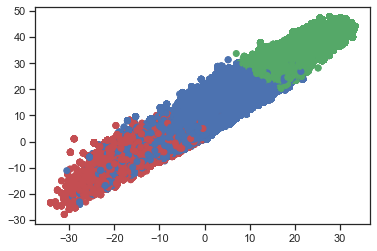

In [63]:
LABEL_COLOR_MAP = {0 : 'r',
                   1 : 'g',
                   2 : 'b',
                   }

label_color = [LABEL_COLOR_MAP[l] for l in cluster_df['Cluster']]
plt.scatter(cluster_df['tmin'],cluster_df['tmax'],c=label_color)
plt.show()

In [162]:
df = cluster_df.groupby(['Cluster'], as_index = False)\
                .agg({'star': 'mean', 'tmin': 'mean', 'tmax': 'mean', 'snow': 'mean', 'snowdepth': 'mean', 'perception': 'mean'})

In [163]:
df

,Cluster,star,tmin,tmax,snow,snowdepth,perception
0,0,3.744037,-11.251325,-2.614232,25.632078,152.223565,3.062656
1,1,3.756613,20.326864,34.013055,0.000000,0.000000,0.604856
2,2,3.737256,4.763862,16.164230,0.368379,1.920738,1.861201


In [164]:
cluster_df['Labels'] = ['Cold' if x == 0 else 'Mild' if x == 2 else 'Hot' for x in cluster_df['Cluster']]

In [76]:
cluster_df.head(5)

,rid,bid,star,tmin,tmax,snow,snowdepth,perception,tmin_sc,tmax_sc,snow_sc,snowdepth_sc,perception_sc,Cluster,Labels
2,nTUJfu-813k56Xt_8tkc0Q,cG6X1idjECJFYUJCAxKgUg,5,1.1,12.03,0.0,0.0,0.0,-1.115106,-1.118126,-0.10581,-0.159945,-0.295171,2,Mild
9,zCOCkT9MbzxqtTcuSCXaxg,-Qkx7W0itbAApcG5lJuMFQ,5,11.5,24.60,0.0,0.0,0.0,-0.101108,-0.044726,-0.10581,-0.159945,-0.295171,2,Mild
10,IXr8mrfUmrO9m1zUQkIUsw,g6mT-GlsxBFZsL1z-b7apQ,4,4.4,16.95,0.0,0.0,0.0,-0.793357,-0.697988,-0.10581,-0.159945,-0.295171,2,Mild
11,6VAT0jFNoI0pe7v_cUajMg,qmIHO-6T_KEfPC9jyGDamQ,4,4.1,17.60,0.0,0.0,0.0,-0.822607,-0.642482,-0.10581,-0.159945,-0.295171,2,Mild
12,VPS7Y29JjakfROwXF8f1ag,3pGA9YGsDLRQ7HJLw5cwcQ,5,2.4,15.20,0.0,0.0,0.0,-0.988356,-0.847427,-0.10581,-0.159945,-0.295171,2,Mild


In [78]:
plot_df = cluster_df.groupby(['Labels'], as_index=False)\
                .agg({'star': 'mean', 'rid': 'nunique'})

ValueError: Could not interpret input 'Labels'

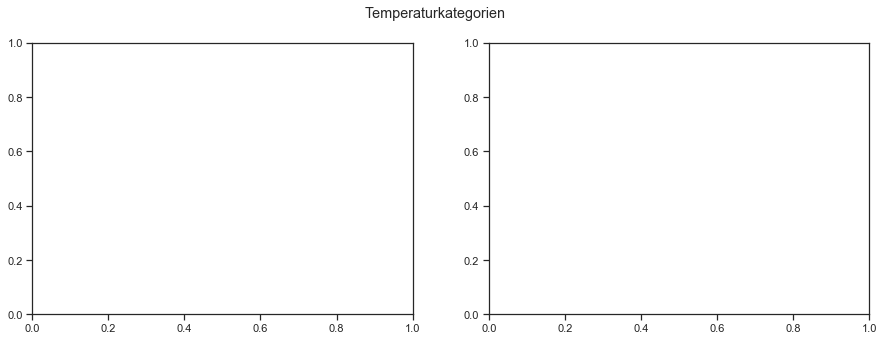

In [161]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Temperaturkategorien ')

sns.set(style='ticks')
sns.barplot(ax = axes[0],
            x = 'Labels',
            y = 'star',
            data = plot_df,
            palette = 'coolwarm',
            order = ['Cold', 'Mild','Hot'])
axes[0].set_title('Niederschlag Kategorien')
axes[1].set_xlabel('')
axes[0].set_ylabel('Durchschnittliche Anzahl Sterne')

show_values_on_bars(axes[0], True)

sns.barplot(ax = axes[1],
            x = 'Labels',
            y = 'rid',
            data = plot_df,
            palette = 'coolwarm',
            log = True,
            order = ['Cold', 'Mild','Hot'])
axes[1].set_title('Anzahl Reviews')
axes[1].set_xlabel('')
axes[1].set_ylabel('Anzahl Reviews')

show_values_on_bars(axes[1], False)

#plt.show()
plt.savefig('cluster_review.png')

# Reviews

In [84]:
df_r['weekday'] = pd.to_datetime(df_r['date']).dt.dayofweek

In [93]:
plot_df = df_r.groupby(['weekday'], as_index = False).agg({'rid': 'count', 'star': 'mean'})

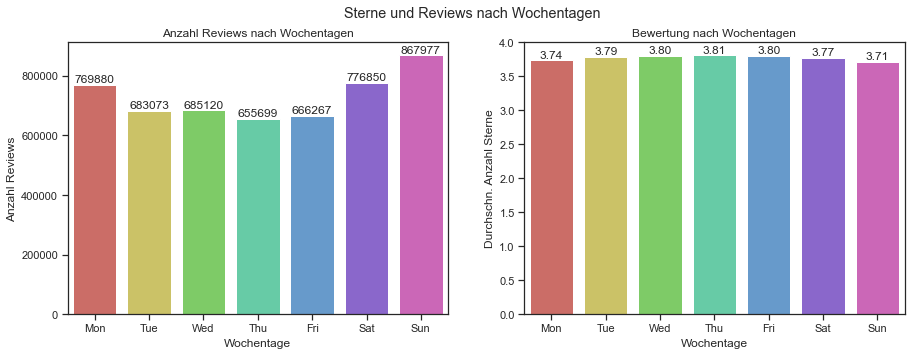

In [103]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Sterne und Reviews nach Wochentagen')

sns.set(style='ticks')
g = sns.barplot(ax = axes[0],
                x = 'weekday',
                y = 'rid',
                data = df_plot,
                palette = 'hls')
axes[0].set_title('Anzahl Reviews nach Wochentagen')
axes[0].set_xlabel('Wochentage')
axes[0].set_ylabel('Anzahl Reviews')
axes[0].set_xticklabels(['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun'])

show_values_on_bars(axes[0], False)

sns.barplot(ax = axes[1],
            x = 'weekday',
            y = 'star',
            data = plot_df,
            palette = 'hls')
axes[1].set_title('Bewertung nach Wochentagen')
axes[1].set_xlabel('Wochentage')
axes[1].set_ylabel('Durchschn. Anzahl Sterne')
axes[1].set_xticklabels(['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun'])

show_values_on_bars(axes[1], True)

plt.show()

# Checkins

In [107]:
df_c['weekday'] = pd.to_datetime(df_c['date']).dt.dayofweek

In [108]:
plot_df = df_c.groupby(['weekday'], as_index = False).agg({'amount': 'sum'})

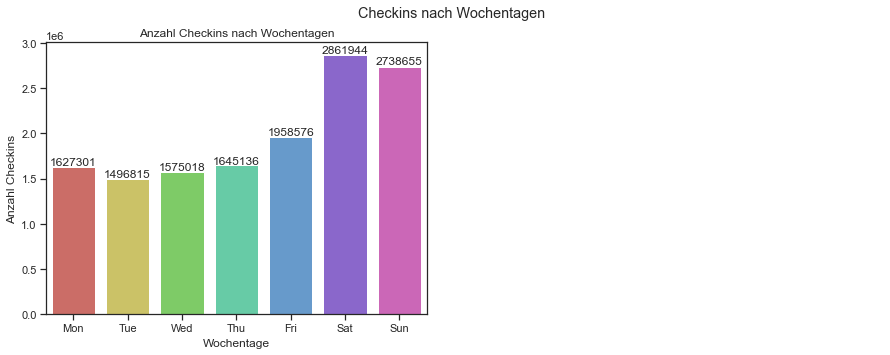

In [123]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Checkins nach Wochentagen')

sns.set(style='ticks')
g = sns.barplot(ax = axes[0],
                x = 'weekday',
                y = 'amount',
                data = plot_df,
                palette = 'hls')
axes[0].set_title('Anzahl Checkins nach Wochentagen')
axes[0].set_xlabel('Wochentage')
axes[0].set_ylabel('Anzahl Checkins')
axes[0].set_xticklabels(['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun'])

show_values_on_bars(axes[0], False)

axes[1].axis('off')
plt.show()